In [5]:
# === train_model_lightgbm.py ===

import pandas as pd
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import pickle

# === CONFIG ===
INPUT_PATH = r"C:\Users\flass\OneDrive\AI Financial Model\S&P 500 Chatgpt Version\df_features_merged.csv"
MODEL_PATH = r"C:\Users\flass\OneDrive\AI Financial Model\S&P 500 Chatgpt Version\lightgbm_model_target2w5_1m7.pkl"
TARGET_COL = "target_2w_5"
DATE_COL = "date"

# === Load dataset ===
print("📂 Loading data from:", INPUT_PATH)
try:
    chunks = pd.read_csv(INPUT_PATH, parse_dates=[DATE_COL], chunksize=100_000)
    df = pd.concat(chunks, ignore_index=True)
except MemoryError:
    print("⚠️ MemoryError encountered. Retrying with engine='python'...")
    df = pd.read_csv(INPUT_PATH, parse_dates=[DATE_COL], engine="python", low_memory=False)

print(f"✅ Loaded data with shape: {df.shape}")
print(f"📅 Date range: {df[DATE_COL].min()} to {df[DATE_COL].max()}")

# === Ensure target column exists and is numeric ===
if TARGET_COL not in df.columns:
    raise ValueError(f"❌ Target column '{TARGET_COL}' not found in dataset.")

print(f"🎯 Using target column: {TARGET_COL}")
df[TARGET_COL] = pd.to_numeric(df[TARGET_COL], errors="coerce")
before_drop = df.shape[0]
df = df.dropna(subset=[TARGET_COL])
print(f"🧹 Dropped {before_drop - df.shape[0]} rows with NaN target")

# === Drop non-numeric columns (except target) ===
non_numeric = df.select_dtypes(include=["object"]).columns
non_numeric = [col for col in non_numeric if col != TARGET_COL]
if non_numeric:
    print("🗑️ Dropping non-numeric columns:", non_numeric)
df = df.drop(columns=non_numeric)

# === Drop known leakage / unsafe columns ===
leakage_cols = [col for col in df.columns if "return_" in col or "target_" in col]
leakage_cols = [col for col in leakage_cols if col != TARGET_COL]
if leakage_cols:
    print("🕵️‍♂️ Dropping potential leakage columns:", leakage_cols)
df = df.drop(columns=leakage_cols)

# === Train-test split ===
df = df.sort_values(DATE_COL)
X = df.drop(columns=[TARGET_COL, DATE_COL])
y = df[TARGET_COL]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, shuffle=False
)

print(f"📊 Training size: {len(X_train)} rows, Validation size: {len(X_val)} rows")
print(f"🧠 Feature count: {X.shape[1]}")

# === Train LightGBM model ===
print("🚀 Training LightGBM model...")
model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)
model.fit(X_train, y_train)

# === Evaluate model ===
print("📈 Evaluating model...")
y_pred_proba = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)
print(f"✅ AUC Score: {auc:.4f}")
print("📋 Classification Report:")
print(classification_report(y_val, model.predict(X_val)))

# === Save model ===
with open(MODEL_PATH, "wb") as f:
    pickle.dump(model, f)

print(f"💾 Model saved to: {MODEL_PATH}")
print("✅ Training pipeline complete.")


📂 Loading data from: C:\Users\flass\OneDrive\AI Financial Model\S&P 500 Chatgpt Version\df_features_merged.csv
✅ Loaded data with shape: (2894127, 124)
📅 Date range: 1997-10-13 00:00:00 to 2025-05-22 00:00:00
🎯 Using target column: target_2w_5
🧹 Dropped 0 rows with NaN target
🗑️ Dropping non-numeric columns: ['ticker', 'sector', 'industry']
🕵️‍♂️ Dropping potential leakage columns: ['return_on_equity', 'target_1m_5_x', 'target_3m_10_x', 'target_3m_15_x', 'target_6m_20_x', 'target_6m_25_x', 'target_1y_30_x', 'target_3m_10_and_6m_20', 'target_3m_15_and_6m_25', 'target_2w_7', 'target_1m_5_y', 'target_1m_7', 'target_1m_10', 'target_3m_10_y', 'target_3m_15_y', 'target_3m_20', 'target_6m_15', 'target_6m_20_y', 'target_6m_25_y', 'target_1y_30_y', 'target_2w_5_and_target_2w_7', 'target_2w_5_and_target_1m_5', 'target_2w_5_and_target_1m_7', 'target_2w_5_and_target_1m_10', 'target_2w_5_and_target_3m_10', 'target_2w_5_and_target_3m_15', 'target_2w_5_and_target_3m_20', 'target_2w_5_and_target_6m_15

                 feature  importance
16          rsi_weekly_7        1058
32        volume_rel_12w         571
15                rsi_28         570
17      price_rel_sma50d         546
9             market_cap         368
22     price_rel_sma156w         351
25            returns_1m         332
23     price_rel_sma260w         311
27           macd_signal         305
10        debt_to_equity         294
5         fwd_eps_growth         268
21      price_rel_sma52w         264
1              ev_ebitda         262
2        sales_growth_1y         251
14                rsi_14         234
4          eps_growth_3y         231
11  free_cash_flow_yield         228
19     price_rel_sma200d         225
18     price_rel_sma100d         206
24            returns_1w         206


<Figure size 1000x600 with 0 Axes>

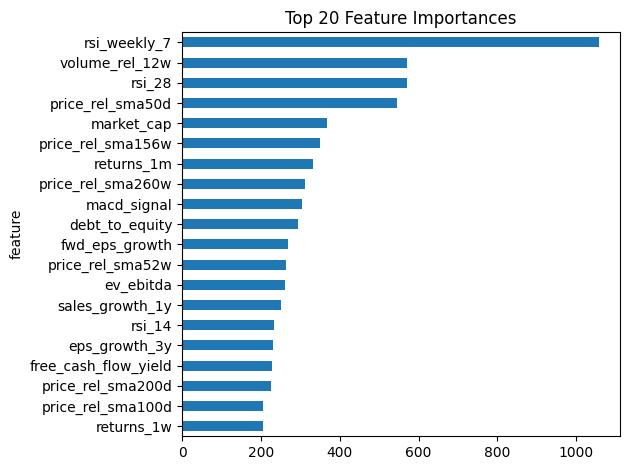

In [6]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Get feature importances
importance = model.feature_importances_
feature_names = model.feature_name_

# Put into a DataFrame
importances_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importance
}).sort_values(by="importance", ascending=False)

# Display top 20
print(importances_df.head(20))

# Plot
plt.figure(figsize=(10, 6))
importances_df.head(20).plot(kind='barh', x='feature', y='importance', legend=False)
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd

# Load the merged dataset
df = pd.read_csv("C:/Users/flass/OneDrive/AI Financial Model/S&P 500 Chatgpt Version/df_features_merged.csv", nrows=100)

# Print all column names
all_columns = df.columns.tolist()

# Print out all technical features (we'll infer by typical prefix or known list)
technical_keywords = ['rsi', 'macd', 'ema', 'sma', 'volatility', 'momentum', 'bb']  # expand this list if needed
technical_features = [col for col in all_columns if any(key in col.lower() for key in technical_keywords)]

print("📊 Technical Features:")
for col in technical_features:
    print(f"• {col}")


📊 Technical Features:
• rsi_14
• macd
• macd_signal
• bb_upper
• bb_lower


In [2]:
import pandas as pd

# === CONFIG ===
FILE_PATH = r"C:\Users\flass\OneDrive\AI Financial Model\S&P 500 Chatgpt Version\df_features_merged.csv"
DATE_COL = "date"
PRICE_COL = "adjusted_close"
VOLUME_COL = "volume"

# === Load just a sample to check columns ===
print("📂 Loading column headers...")
df_sample = pd.read_csv(FILE_PATH, nrows=100)
available_columns = df_sample.columns.tolist()

required_columns = [DATE_COL, PRICE_COL, VOLUME_COL]

# === Check if required columns are present ===
print("\n🔎 Required column check:")
for col in required_columns:
    if col in available_columns:
        print(f"✅ {col} is present")
    else:
        print(f"❌ {col} is MISSING")

# === Check for date granularity (daily) ===
print("\n📆 Checking date granularity...")
df = pd.read_csv(FILE_PATH, usecols=[DATE_COL], parse_dates=[DATE_COL])
df = df.drop_duplicates()
df['day_diff'] = df[DATE_COL].diff().dt.days

daily_counts = df['day_diff'].value_counts().sort_index()
print("\n🗓️ Date interval distribution:")
print(daily_counts)

if 1 in daily_counts.index:
    print("✅ Daily granularity supported")
else:
    print("⚠️ Daily granularity not detected")

# === Optional: Check data spans enough time for weekly RSI ===
print("\n⏳ Checking date range and duration...")
print(f"Start: {df[DATE_COL].min()}, End: {df[DATE_COL].max()}")
print(f"Total unique dates: {len(df)}")


📂 Loading column headers...

🔎 Required column check:
✅ date is present
❌ adjusted_close is MISSING
❌ volume is MISSING

📆 Checking date granularity...

🗓️ Date interval distribution:
day_diff
-10083.0       1
 1.0        5437
 2.0          67
 3.0        1254
 4.0         183
 5.0           2
 7.0           1
Name: count, dtype: int64
✅ Daily granularity supported

⏳ Checking date range and duration...
Start: 1997-10-13 00:00:00, End: 2025-05-22 00:00:00
Total unique dates: 6946


In [3]:
import pandas as pd

# Path to your large merged features file
file_path = r"C:\Users\flass\OneDrive\AI Financial Model\S&P 500 Chatgpt Version\df_features_merged.csv"

# Load just the first 100 rows to reduce memory usage
print("📂 Loading partial dataset to inspect columns...")
df = pd.read_csv(file_path, nrows=100)

# Display all columns
print(f"🔍 Total columns: {len(df.columns)}\n")
print("📋 Feature columns:")
for col in df.columns:
    print("•", col)

# Flag junk/undesirable financial features (manually curated)
junk_keywords = [
    "stockBasedCompensation", "exchangeRateChanges", "changeToAccountReceivables",
    "salePurchaseOfStock", "changeToOperatingActivities",
    "otherCashflowsFromInvestingActivities"
]

print("\n🚫 Potential junk features found:")
for col in df.columns:
    if any(key in col for key in junk_keywords):
        print("❌", col)


📂 Loading partial dataset to inspect columns...
🔍 Total columns: 24

📋 Feature columns:
• ticker
• date
• pe_ttm_x
• ev_ebitda
• sales_growth_1y
• sales_growth_3y
• eps_growth_3y
• fwd_eps_growth
• pe_rel_index_x
• pe_rel_self_3y_avg
• pe_rel_rel_self_vs_index_3y
• market_cap
• debt_to_equity
• free_cash_flow_yield
• return_on_equity
• pe_ttm_y
• pe_rel_index_y
• rsi_14
• macd
• macd_signal
• returns_1w
• returns_1m
• bb_upper
• bb_lower

🚫 Potential junk features found:
